### Tyler Cole
### Final Project
### 8 May 2020

#### Introduction
The purpose of this project is to analyze the coronavirus patient data in order to find trends in the data that may help in better understanding what groups of people are at risk. In this report death rates and recovery rates are analyzed for different age groups. Graphs representing death and recovery rates per age group have the ages grouped in 10 year increments. For example, 10 represents ages 10 through and including 19. After analyzing death and recovery rates this report aims to find a model that has the ability to predict patients who are at the highest risk of death. A naive bayes classifier as well as a K-nearest-neighbors classifier are trained in order to make these fatality predictions.


In [44]:
import pandas as pd
from matplotlib import pyplot
import numpy as np

df = pd.read_csv('coronavirus-cases.csv', header=1, parse_dates=True)
df_patient = df.drop(columns=['id', 'summary', 'location', 'symptom_onset', 'traveler', 'hosp_visit_date', 'If_onset_approximated', 'visiting Wuhan', 'from Wuhan', 'international_traveler', 'domestic_traveler', 'case_in_country', 'source', 'link'])

#start cleaning data
df_patient = df_patient.fillna(0)
df_patient.loc[(df_patient.death == '0'), 'death'] = 0
df_patient.loc[(df_patient.death != 0), 'death'] = 1
df_patient.loc[(df_patient.age == 0.0), 'age'] = None
df_patient.loc[(df_patient.recovered == '0'), 'recovered'] = 0
df_patient.loc[(df_patient.recovered != 0), 'recovered'] = 1
df_patient

,reporting_date,country,gender,age,exposure_start,exposure_end,death,recovered,symptom
0,1/20/2020,China,male,66.0,12/29/2019,1/4/2020,0,0,0
1,1/20/2020,China,female,56.0,0,1/12/2020,0,0,0
2,1/21/2020,China,male,46.0,0,1/3/2020,0,0,0
3,1/21/2020,China,female,60.0,0,0,0,0,0
4,1/21/2020,China,male,58.0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
3392,2/27/2020,Switzerland,male,26.0,0,0,0,0,0
3393,2/27/2020,Switzerland,female,30.0,0,0,0,0,0
3394,2/27/2020,Switzerland,male,49.0,0,0,0,0,0
3395,2/27/2020,Switzerland,female,NaN,0,0,0,0,0


In [45]:
df_patient.describe()

,age,death,recovered
count,1507.000000,3397.000000,3397.000000
mean,51.040312,0.024433,0.053871
std,18.813253,0.154413,0.225796
min,0.250000,0.000000,0.000000
25%,36.000000,0.000000,0.000000
50%,54.000000,0.000000,0.000000
75%,65.000000,0.000000,0.000000
max,96.000000,1.000000,1.000000


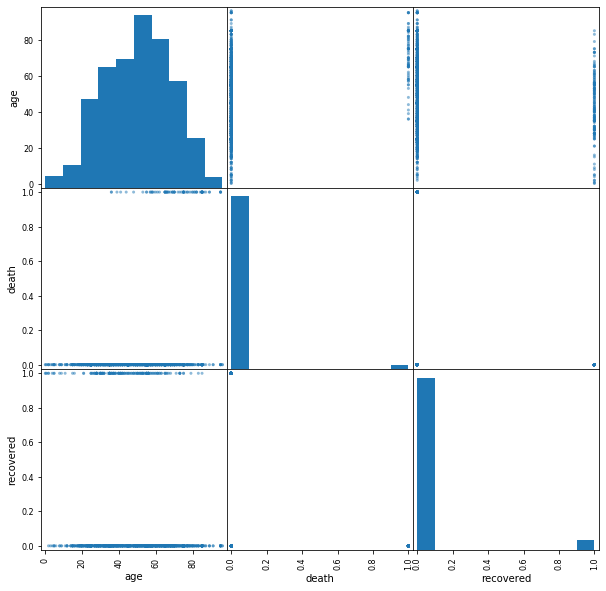

In [46]:
null = pd.plotting.scatter_matrix(df_patient, figsize=[10,10])

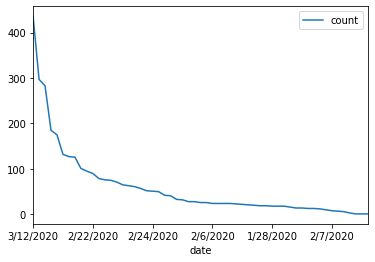

In [172]:
df_case_by_date = pd.DataFrame(df_patient.reporting_date.value_counts())
df_case_by_date.reset_index(level=0, inplace=True)
df_case_by_date = df_case_by_date.rename(columns={'index': 'date', 'reporting_date': 'count'})
df_case_by_date = df_case_by_date.loc[df_case_by_date['date'] != 0]
df_case_by_date.plot(x='date', y='count')

,age,count,deaths,recovered,percent_death,percent_recovered
0,0.0,21,0.0,10.0,0.000000,47.619048
1,10.0,40,0.0,3.0,0.000000,7.500000
2,20.0,170,0.0,19.0,0.000000,11.176471
3,30.0,211,3.0,39.0,1.421801,18.483412
4,40.0,229,3.0,31.0,1.310044,13.537118
5,50.0,317,9.0,39.0,2.839117,12.302839
6,60.0,260,18.0,16.0,6.923077,6.153846
7,70.0,175,19.0,8.0,10.857143,4.571429
8,80.0,71,22.0,2.0,30.985915,2.816901
9,90.0,13,4.0,0.0,30.769231,0.000000


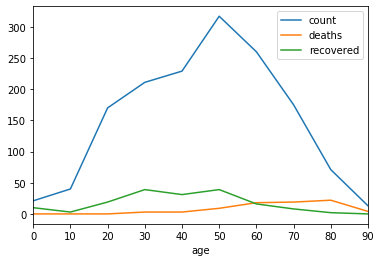

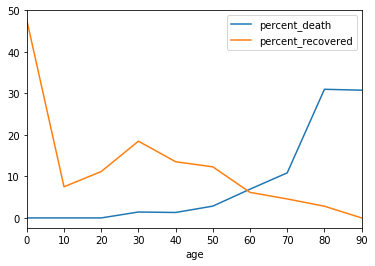

In [48]:
#clean data
death_index = df_patient.loc[ df_patient['death'] == 1]
recover_index = df_patient.loc[ df_patient['recovered'] == 1]
df_death_by_age = pd.DataFrame(death_index, columns=['age', 'death'])
recover_by_age = pd.DataFrame(recover_index, columns=['age', 'recovered'])
death_values_by_age = df_death_by_age.age.value_counts()
recover_by_age = pd.DataFrame(recover_by_age.age.value_counts())
death_values_by_age = pd.DataFrame(death_values_by_age)
death_values_by_age.reset_index(level=0, inplace=True)
recover_by_age.reset_index(level=0, inplace=True)
death_values_by_age = death_values_by_age.rename(columns={'age': 'deaths', 'index': 'age'})
recover_by_age = recover_by_age.rename(columns={'age': 'recovered', 'index': 'age'})
death_values_by_age = death_values_by_age.sort_values(by=['age'])
recover_by_age = recover_by_age.sort_values(by=['age'])

#organize ages in 10year increments for better visualization
for i in range(0,100,10):
    death_values_by_age.loc[death_values_by_age['age'].isin(range(i,i+10)), 'age'] = i
    recover_by_age.loc[recover_by_age['age'].isin(range(i, i+10)), 'age'] = i
    
recover_by_age.loc[recover_by_age.age < 1, 'age'] = 0.00
    
for i in recover_by_age['age'].unique():
    death_values_by_age.loc[death_values_by_age['age'] == i, 'deaths'] = death_values_by_age.loc[death_values_by_age['age'] == i, 'deaths'].sum()
    recover_by_age.loc[recover_by_age['age'] == i, 'recovered'] = recover_by_age.loc[recover_by_age['age'] == i, 'recovered'].sum()
    
    
death_by_age = death_values_by_age.drop_duplicates()
recover_by_age = recover_by_age.drop_duplicates()
plot = pd.merge(death_by_age, recover_by_age, how='outer', on='age')
plot = plot.sort_values(by=['age'])
plot = plot.fillna(0)

#Add percent deaths by age
percent_by_age = pd.DataFrame(df_patient, columns=['age'])
percent_by_age = percent_by_age[percent_by_age['age'].notna()]

for i in range(0,100,10):
    percent_by_age.loc[percent_by_age['age'].isin(range(i,i+10)), 'age'] = i
    
percent_by_age.loc[percent_by_age.age < 1, 'age'] = 0.00
    
percent_by_age = pd.DataFrame(percent_by_age.age.value_counts())
percent_by_age.reset_index(level=0, inplace=True)
percent_by_age = percent_by_age.rename(columns={'age': 'count', 'index': 'age'})
percent_by_age = percent_by_age.sort_values(by=['age'])

percent_by_age = pd.merge(percent_by_age, plot, how='inner', on='age')
percent_by_age['percent_death'] = percent_by_age.apply(lambda row: (row['deaths'] / row['count'])*100, axis=1)
percent_by_age['percent_recovered'] = percent_by_age.apply(lambda row: (row['recovered'] / row['count'])*100, axis=1)
percent_by_age.plot(x='age', y=['count', 'deaths', 'recovered'])
percent_by_age.plot(x='age', y=['percent_death', 'percent_recovered'])
percent_by_age

#### Analysis of Visualization 
Question: How quickly are cases growing?
- Methods: To answer this a line graph is shown to demonstrate the curve of infections. A new data frame was constructed that contained the unique date values and counts of the reported cases for each of those dates.
- Analysis: From this graph it is clear that the rate of new infections per day is increasing exponentially but as the dataset is on the smaller side it is by no means a perfect representation of an actual curve in cases. Seeing a curve result from this method was promising however, because it aligned with reports that had been coming out on new infection rates per day up until that point.
- Conclusion: Infection rates were clearly increasing at an exponential rate indicating that the virus is highly contagious and that mitigation strategies were necessary.


Question: What are the primary ages represented in this dataset?
- Methods: A scatter matrix proved useful in analyzing the representation from different age groups in this dataset.
- Analysis: The scatter matrix compared the age, death, and recovery columns to each other in order to demonstrate how represented each age is.
- Conclusion: By looking at all of the graphs that include age it can be concluded that ages 20 to 80 are the most represented age groups. This indicates that people less than 20 years old are less likely to have their condition worsen to the point where they feel they should be tested. An important conclusion that can be drawn from this is that adults are more likely to be tested and or show symptoms of the virus.


Question: What are the death and recovery rates for various age groups?
- Methods: In order to answer this question the data needed to be organized better. A data frame was created that contained the total cases, deaths, and recoveries for each age group. This data set was then used to create a new data set that included the percentage of people who recover and die in each age group. For these graphs each number represents a 10 year group as stated in the introduction (Ex. 10 = 10-19) .
- Analysis: After a data set was created showing these values 2 graphs were plotted. The first graph contains the total number of cases in each age group along with the total number of deaths and recoveries for these groups. The second graph demonstrates recovery rates and death rates for each age group.
- Conclusion: The first graph again shows that the majority of people represented in this data set are of ages 20 to 80. An important finding from both of these charts comes at the age range 60-69. This is the age range in which the recovery number and recovery rate drop below the death number and death rate for this data set. This is significant because it highlights an age group (people over 60) that should be taking this virus extremely seriously. Another important conclusion to draw from this dataset is that death rates do not exceed 2% until after the age of 50. These conclusions help to demonstrate that this virus, while being dangerous to many, is primarily dangerous to the elderly. 


In [123]:
from sklearn.model_selection import cross_val_score
from re import sub
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

#clean data
NB_table = pd.DataFrame(df_patient, columns=['death', 'symptom'])
NB_table = NB_table.fillna(-1)
NB_table = NB_table.loc[NB_table.symptom != -1]
NB_table = NB_table.loc[NB_table.symptom != 0]
symptom = pd.DataFrame(NB_table, columns=['symptom'])
death = pd.DataFrame(NB_table.death, columns=['death'])
death.loc[(death.death == 1), 'death'] = 'Dead'
death.loc[(death.death == 0), 'death'] = 'Alive'
symptom = symptom.astype(str)
death.death = death.death.astype(str)
symptom

,symptom
194,"feaver, cough, difficult in breathing"
195,"feaver, cough, difficult in breathing"
196,fever
253,fever
257,fever
...,...
3074,fever
3213,"fever, cough, sore throat"
3216,fever
3227,"sore throat, fever"


In [148]:
stemmer = PorterStemmer()

#prepare data for symptoms
new_symptom = []
for i in range(symptom.shape[0]):
    new_symptom.append(sub("[^a-zA-Z]", " ", symptom.iloc[i, 0]))

lowercase_symptom = []
for i in range(len(new_symptom)):
    lowercase_symptom.append(new_symptom[i].lower())

stemmed_symptom = []
for i in range(len(lowercase_symptom)):
    symptom_words = lowercase_symptom[i].split()

    stemmed_symptom_words = []
    for i in symptom_words:
        stemmed_symptom_words.append(stemmer.stem(i))         
    stemmed_symptom.append(" ".join(stemmed_symptom_words))
    

vectorizer = CountVectorizer()
docarray = vectorizer.fit_transform(stemmed_symptom).toarray()
coords = vectorizer.get_feature_names()
docterm = pd.DataFrame(data=docarray,columns=coords)

#model and cross validation
model = MultinomialNB()
scores_symptom = cross_val_score(model, docarray, death.values.ravel(), cv=5)

print("docarray shape: {}".format(docarray.shape))
print("first 10 coords: {}".format(vectorizer.get_feature_names()[:10]))
print("Text Model Fold Accuracies: {}".format(scores_symptom))
print("Text Model XV Accuracy: {: 6.2f}%".format(scores_symptom.mean()*100))

*** Data Prepared ***
**** Vector Model Prepared ****
docarray shape: (338, 60)
first 10 coords: ['abdomin', 'ach', 'appetit', 'back', 'bodi', 'breath', 'breathless', 'chest', 'chill', 'cold']
Text Model Fold Accuracies: [0.94117647 0.97058824 0.97058824 0.95588235 0.96969697]
Text Model XV Accuracy:  96.16%


In [154]:
#KNN for Age, Gender, Hospitalization and Death
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from bootstrap import bootstrap

#clean data
Knn_data = pd.DataFrame(df_patient, columns=['gender', 'age', 'hosp_visit', 'death'])
Knn_data = Knn_data.loc[Knn_data['gender'].isin(['male', 'female'])]
Knn_data = Knn_data.fillna(-1)
Knn_data.loc[Knn_data['gender'] == 'male', 'gender'] = 1
Knn_data.loc[Knn_data['gender'] == 'female', 'gender'] = 0
Knn_data = Knn_data.loc[Knn_data['age'] != -1]
Knn_data.loc[Knn_data['hosp_visit'] == -1, 'hosp_visit'] = 0
Knn_data.loc[Knn_data['hosp_visit'] != 0, 'hosp_visit'] = 1
Knn_data.loc[Knn_data['death'] == -1, 'death'] = 0
Knn_data.loc[Knn_data['death'] != 0, 'death'] = 1
Knn_X = Knn_data.drop(['death'], axis=1)
Knn_y = Knn_data['death']

#build model
model = KNeighborsClassifier()
param_grid = {'n_neighbors': list(range(1,30))}
grid = GridSearchCV(model, param_grid, cv=5)
train_X, test_X, train_y, test_y = train_test_split(Knn_X, Knn_y, train_size=0.8, test_size=0.2)
grid.fit(train_X, train_y)
print("Grid Search: best parameters: {}".format(grid.best_params_))
predict_y = grid.best_estimator_.predict(test_X)
print("Train-Test Accuracy: {}".format(accuracy_score(test_y, predict_y)))

#cross validation
scores = cross_val_score(grid.best_estimator_, Knn_X, Knn_y, cv=5)
print("Fold Accuracies: {}".format(scores))
print("XV Accuracy: {}".format(scores.mean()))
print("Confidence interval best KNN: {}".format(bootstrap(grid.best_estimator_,Knn_data,'death')))

Grid Search: best parameters: {'n_neighbors': 12}
Train-Test Accuracy: 0.9620689655172414
Fold Accuracies: [0.94501718 0.94501718 0.94809689 0.94463668 0.92041522]
XV Accuracy: 0.9406366306377008
Confidence interval best KNN: (0.9206896551724137, 0.9690517241379312)


#### Model Analysis

Question: Can a model be trained to predict fatalities (based on symptoms) with an acceptable accuracy range (70-98%)?

- Methods: A Naive Bayse classifier was used for this question. The data was first transformed into lowercase strings with no special characters, then the words were stemmed before going through the vectorization process.
- Analysis: This model produced a cross validated accuracy of 96.16% simply by analyzing the reported symptoms and comparing them to reported deaths. 
- Conclusion: 96.16% accuracy based on only symptoms is significant because this indicates that  it is quite possible to predict if a person is likely to die with a certain set of symptoms. If this is applied to a more complete data set it can lead to better prioritization of hospital patients and, as a result,  possibly less death. One thing to be noted about this model, however, is that there were only 338 patients with reported symptoms in this dataset. This is a relatively low number of inputs for this kind of classification so an accuracy scored on a more complete data set is likely to be lower.


Question: Can a model be trained to predict fatalities (based on age, gender, and if the patient has gone to the hospital) with an acceptable accuracy range (70-98%)?

- Methods: For this question a K-nearest-neighbors classifier was trained in order to group cases for prediction. The data was first converted to numerical values then broken into a training and testing set in order to better predict its accuracy when applied to a different dataset.
- Analysis: This model produced 96.21% accuracy on the testing data set, 94.6% accuracy for the cross validated accuracy, and a confidence interval of 92.07% to 96.91%. The best parameter for n_neighbors happened to be 12.
- Conclusion: The “cleaned up” data set for this model ended up being about 3 times as large as the “cleaned up” data set for the Naive Bayse model and produced very similar accuracy scores. Similar conclusions can be drawn from this model but it being dependent on age, gender, and if the patient has visited the hospital could possibly allow for earlier predictions. Since the training data set is larger for this model and relies on simple categories, rather than symptoms, it is likely that this model would see a much higher accuracy score, when applied to a larger data set, than the symptom model. 


#### Final Conclusions
Through working with this data set, trends can be found that apply out into the world. The similarities between the curve with new cases in this data set and the curves being reported by the media demonstrates that this data set while not being perfect can represent trends in all cases with some accuracy. A very important conclusion to draw from this analysis is that the data clearly shows hightened risk with age; especially if a patients age is over 60. Most importantly, finding that models can be trained to make fatality predictions based on several different categories could prove to be useful in the future if there is another surge in cases resulting in doctors needing to prioritize patients.

#### Apendix
###### - Data Source: 
- https://docs.google.com/spreadsheets/d/1jS24DjSPVWa4iuxuD4OAXrE3QeI8c9BC1hSlqr-NMiU/edit#gid=1187587451